In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rank-gauss/rankGaussTrafo.py
/kaggle/input/rank-gauss/rgn.py
/kaggle/input/rank-gauss/gauss_rank_scaler.py
/kaggle/input/flats/flats.csv


In [2]:
exec(open("/kaggle/input/rank-gauss/gauss_rank_scaler.py").read())
#os.startfile(r'/kaggle/input/rank-gauss/gauss_rank_scaler.py') 

# Мини-проект по теме Байесовские методы в машинном обучении

## Задание

Сделать первичный анализ, подготовить признаки, которые будут использоваться и проанализировать их распределения.

Сделайть модель байесовской линейной регрессии с выбранными признаками.

На тех же самых признаках построить линейную регрессию и сравнить получившиеся коэффициенты классической линейной регрессии с коэффициентами при признаках в байесовской линейной регрессии.  

Загрузим необходимые библиотеки.

In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Загрузим наши данные и посмотрим на них.

In [4]:
df = pd.read_csv("../input/flats/flats.csv")

In [5]:
df.head(10)

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
0,8056,2750000,11,11.0,1.0,12.0
1,8154,7100000,45,27.0,2.0,6.0
2,8287,11700000,77,50.0,3.0,8.0
3,8387,10400000,56,29.0,2.0,10.0
4,8391,6200000,31,21.0,1.0,5.0
5,8410,5950000,43,27.0,2.0,5.0
6,8423,5900000,46,29.0,2.0,5.0
7,8427,2000000,45,29.0,2.0,6.0
8,8452,4500000,38,24.0,2.0,5.0
9,8470,4569600,54,32.0,2.0,9.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6042 entries, 0 to 6041
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6042 non-null   int64  
 1   price_doc   6042 non-null   int64  
 2   full_sq     6042 non-null   int64  
 3   life_sq     6042 non-null   float64
 4   num_room    6042 non-null   float64
 5   kitch_sq    6042 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 283.3 KB


# EDA

Посмотрим на количество встречающихся значений по всем признакам

In [7]:
df.nunique().sort_values()

num_room        11
kitch_sq        41
life_sq        131
full_sq        163
price_doc     1071
Unnamed: 0    6042
dtype: int64

In [8]:
df.describe()

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
count,6042.000000,6.042000e+03,6042.000000,6042.000000,6042.000000,6042.000000
mean,19846.990070,8.750423e+06,53.374545,33.198941,1.997021,7.391096
std,6081.011373,6.277290e+06,24.011941,20.190005,0.889523,3.806198
min,8056.000000,5.000000e+05,1.000000,0.000000,0.000000,0.000000
25%,14573.250000,5.800000e+06,38.000000,20.000000,1.000000,5.000000
50%,19871.500000,7.400000e+06,46.000000,29.000000,2.000000,7.000000
75%,25147.750000,1.050000e+07,63.000000,42.000000,3.000000,9.000000
max,30470.000000,9.512250e+07,637.000000,637.000000,17.000000,96.000000


Судя по всему, в данных есть некорректные значения:   
    1. Значения full_sq	меньше значений life_sq   
    2. Нулевые значения в значениях столбцов life_sq, num_room, kitch_sq  
    
Для начала уберем нули в столбцах num_room, kitch_sq. Если в столбце num_room стоит 0, заменим его на 1 (на минимум комнат).
В столбце kitch_sq заменим все значения менее 5, на 5. (Кухня должна иметь площадь не менее восьми квадратных метров, в то же время для однокомнатных квартир существуют минимальные требования по площади кухни в шесть квадратных метров. Кухни-ниши должны занимать не менее пяти «квадратов».)
Минимальная площадь life_sq не должна быть меньше 14 м2.



In [9]:
df.loc[(df.num_room == 0), 'num_room'] = 1

In [10]:
df.loc[(df.kitch_sq < 5), 'kitch_sq'] = 5

In [11]:
df.loc[(df.life_sq < 14), 'life_sq'] = 14

In [12]:
df.loc[(df.full_sq < (df.life_sq+df.kitch_sq)), 'full_sq'] = df.life_sq+df.kitch_sq

In [13]:
df = df.reindex(columns=['price_doc','Unnamed: 0','full_sq', 'life_sq','num_room', 'kitch_sq'])

Посмотрим на распределения признаков.

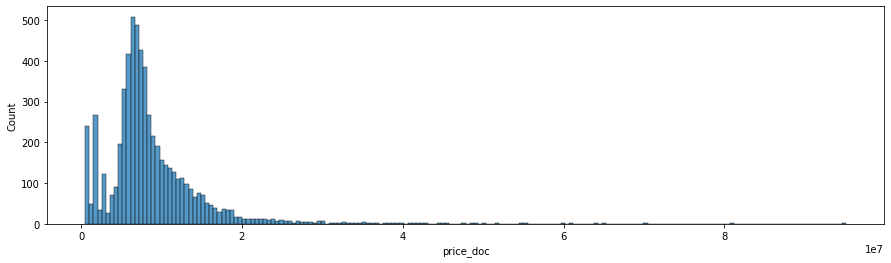

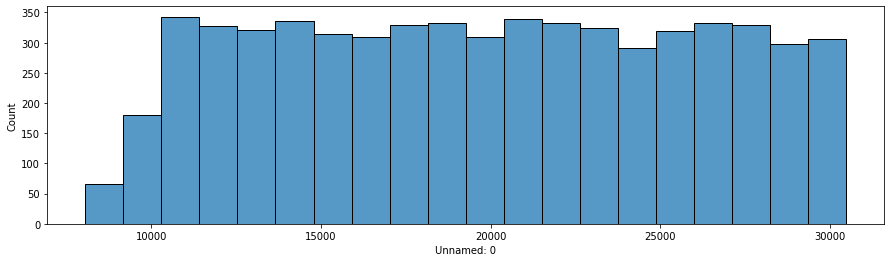

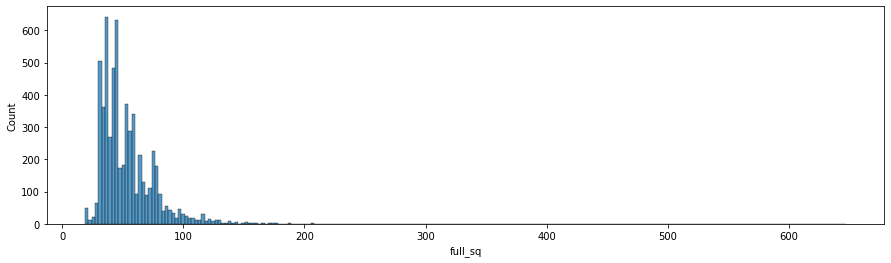

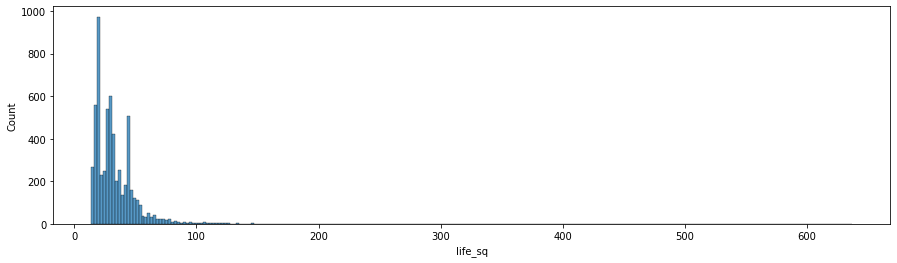

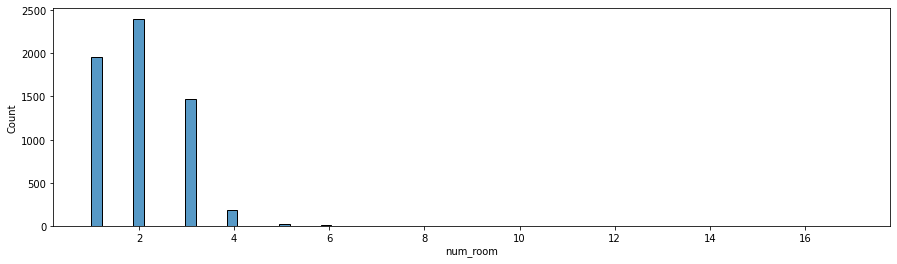

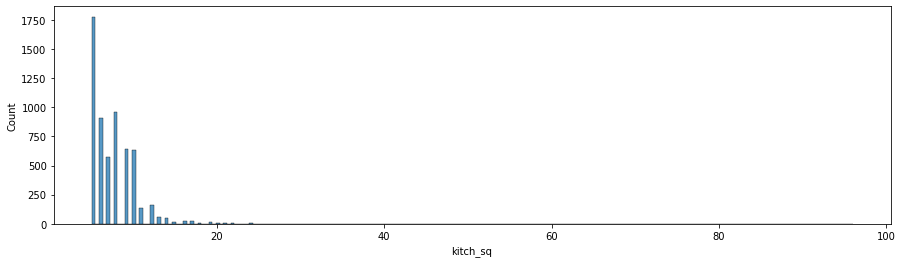

In [14]:
for c in df.columns:

    fig, axes = plt.subplots(1, 1, figsize=(15, 4))
    sns.histplot(df[c], kde=False, ax=axes)

Построим boxplot’ы для всех переменных.

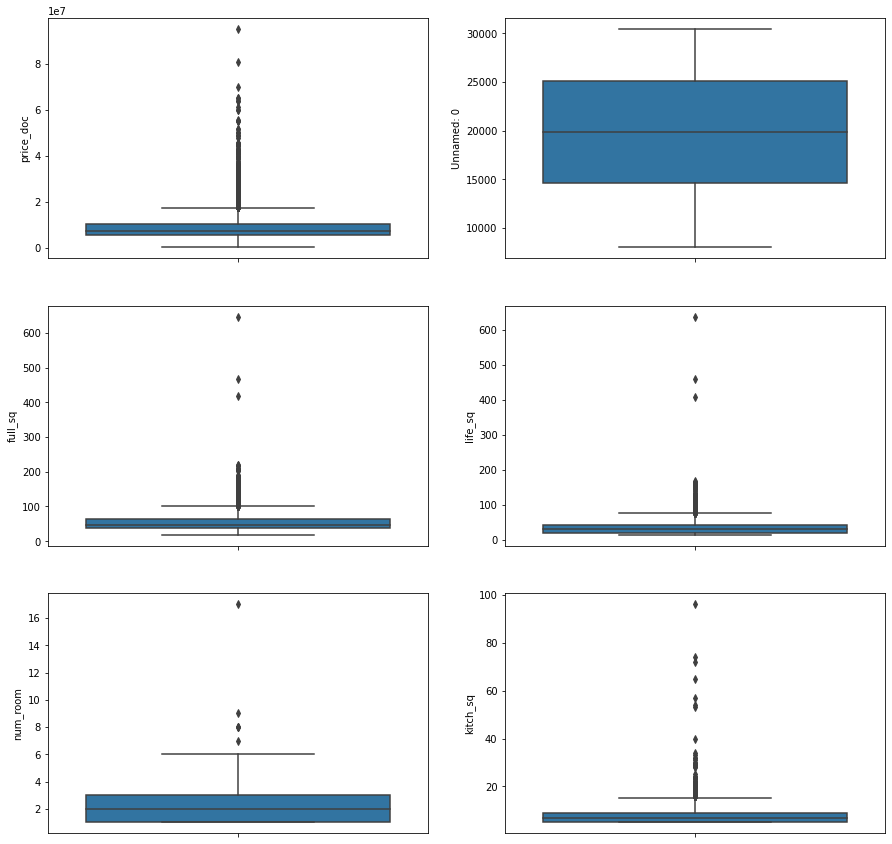

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for col, i in zip(df.columns, range(len(df.columns))):
    sns.boxplot( y=col, data=df, ax=axes.flat[i])

Прологарифмируем нашу целевую переменную и нормализуем остальные признаки.

In [16]:
col = ['Unnamed: 0','full_sq', 'life_sq','num_room', 'kitch_sq']
scaler = StandardScaler()
df_new = scaler.fit_transform(df[col].values)

df_new = np.log1p(df)

In [17]:
df_new

,price_doc,Unnamed: 0,full_sq,life_sq,num_room,kitch_sq
0,14.827112,8.994297,3.295837,2.708050,0.693147,2.564949
1,15.775605,9.006387,3.828641,3.332205,1.098612,1.945910
2,16.275099,9.022564,4.356709,3.931826,1.386294,2.197225
3,16.157316,9.034557,4.043051,3.401197,1.098612,2.397895
4,15.640060,9.035034,3.465736,3.091042,0.693147,1.791759
...,...,...,...,...,...,...
6037,16.171074,10.324268,3.871201,3.433987,0.693147,2.397895
6038,16.300417,10.324301,4.043051,3.401197,1.098612,2.484907
6039,17.034386,10.324432,4.465908,4.094345,1.609438,2.397895
6040,16.418200,10.324498,4.174387,3.496508,1.098612,2.484907


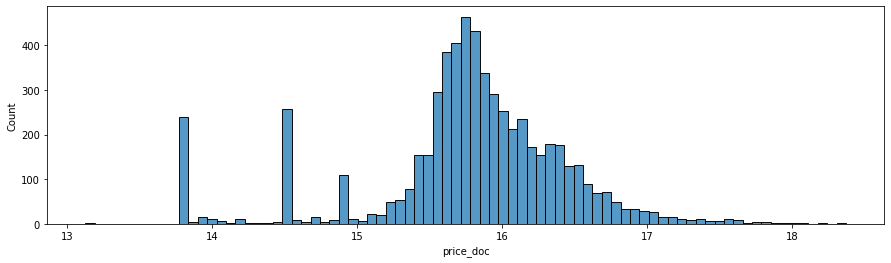

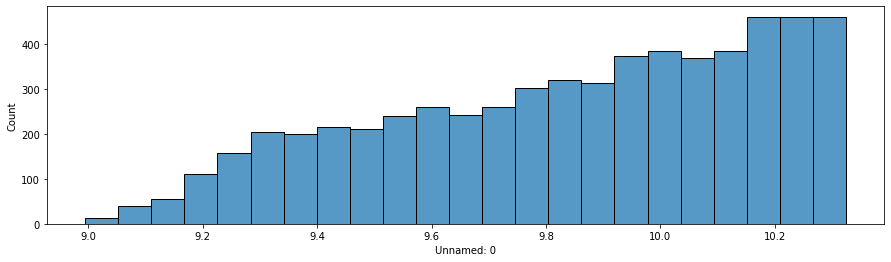

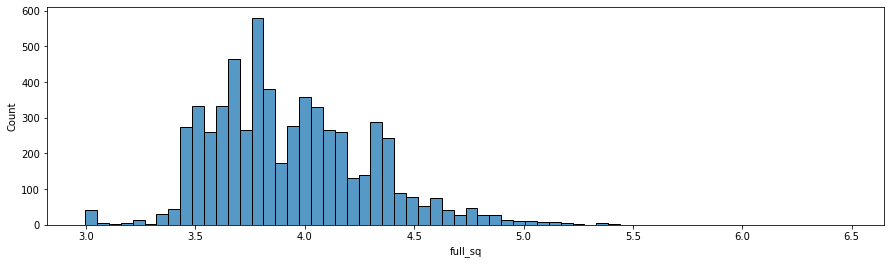

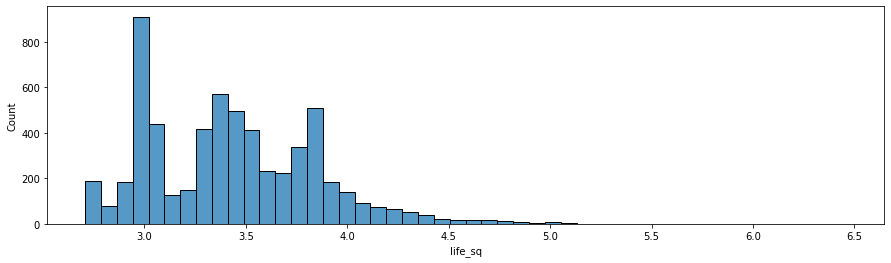

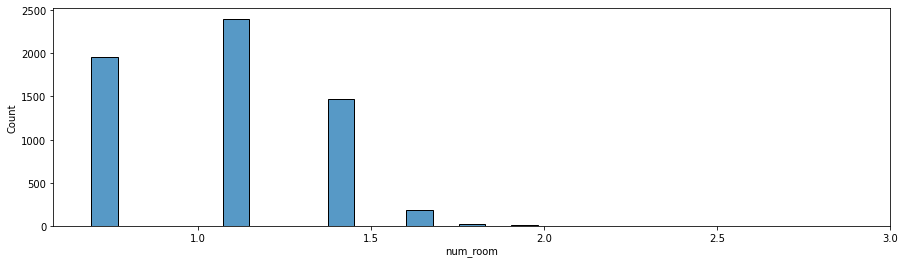

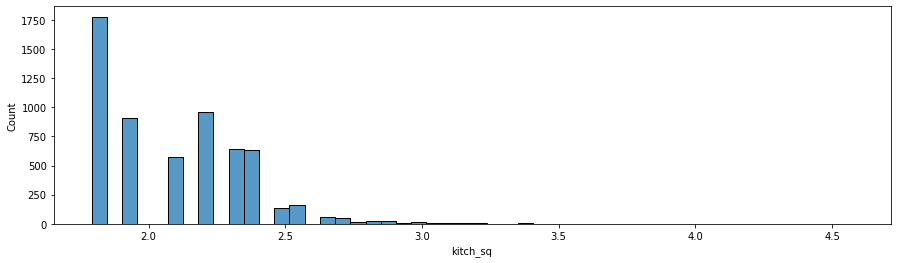

In [18]:
for c in df_new.columns:

    fig, axes = plt.subplots(1, 1, figsize=(15, 4))
    sns.histplot(df_new[c], kde=False, ax=axes)

Судя по графикам, требуется нормализация распределений. Проведем нормализацию.

<AxesSubplot:title={'center':'Значимость числовых переменных'}>

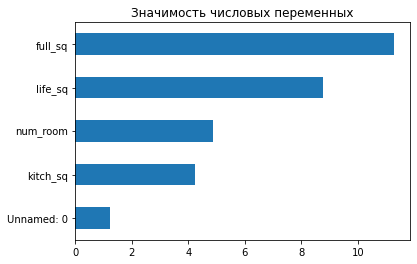

In [19]:
from sklearn.feature_selection import f_classif
imp_num = pd.Series(f_classif(df_new[['Unnamed: 0','full_sq', 'life_sq','num_room', 'kitch_sq']], df['price_doc'])[
                    0], index=['Unnamed: 0','full_sq', 'life_sq','num_room', 'kitch_sq'])
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', title='Значимость числовых переменных')

In [20]:
df_new = df_new[['price_doc','full_sq', 'life_sq','num_room', 'kitch_sq']]

# Байесовская линейная регрессия

In [21]:
with pm.Model() as linear_model:
    pm.glm.GLM.from_formula('price_doc ~ full_sq + life_sq + num_room + kitch_sq ', df_new) 
    trace = pm.sample(1000)
    
    #trace = pm.sample(1000, init="adapt_diag")

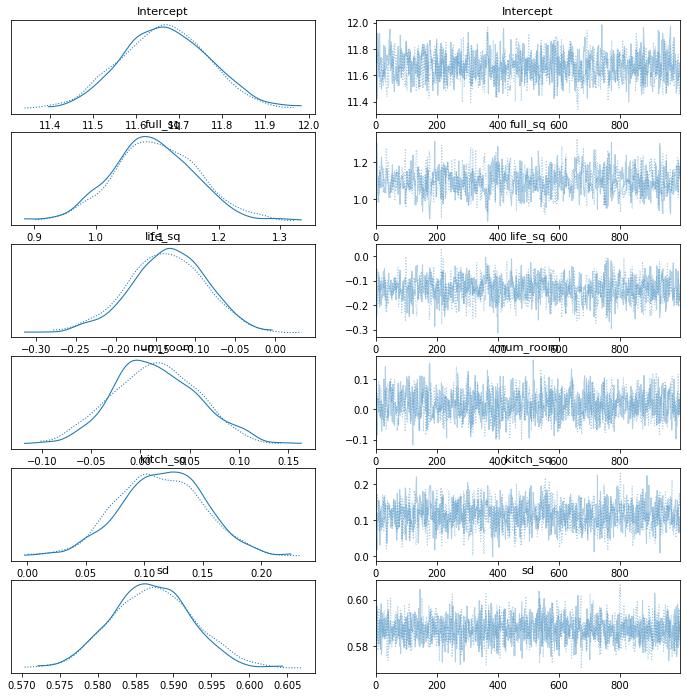

In [22]:
az.plot_trace(trace);

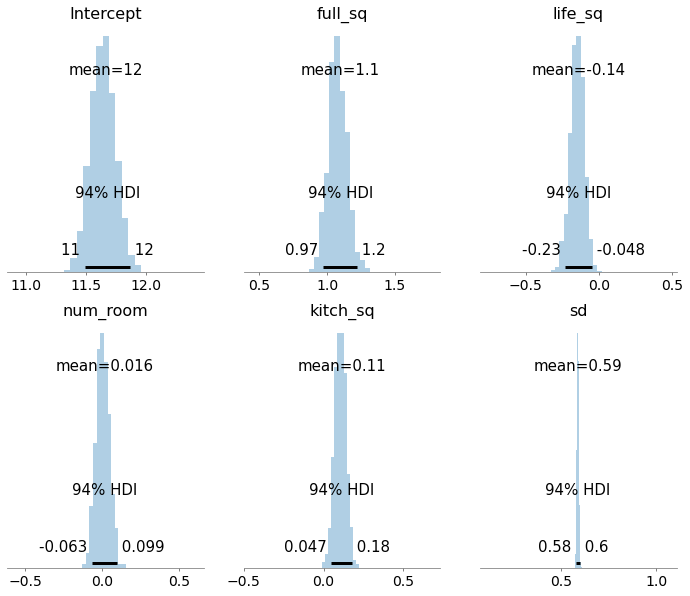

In [23]:
pm.plot_posterior(trace, figsize = (12, 10), kind="hist");

In [24]:
bayes_summary = pm.summary(trace).round(2)
bayes_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,11.67,0.10,11.49,11.87,0.0,0.0,874.0,998.0,1.0
full_sq,1.10,0.07,0.97,1.22,0.0,0.0,616.0,919.0,1.0
life_sq,-0.14,0.05,-0.23,-0.05,0.0,0.0,854.0,1054.0,1.0
num_room,0.02,0.04,-0.06,0.10,0.0,0.0,1001.0,1266.0,1.0
kitch_sq,0.12,0.04,0.05,0.18,0.0,0.0,800.0,912.0,1.0
sd,0.59,0.00,0.58,0.60,0.0,0.0,1719.0,1092.0,1.0


# Классическая линейная регрессия

In [25]:
lr = LinearRegression()
lr.fit(df_new.drop(columns='price_doc'), df_new['price_doc'])

ols_formula = 'price_doc = %0.2f * %s +' % (lr.intercept_,'Intercept')
for i, col in enumerate(df_new.drop(columns='price_doc').columns):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[i], col)
    
' '.join(ols_formula.split(' ')[:-1])

'price_doc = 11.67 * Intercept + 1.10 * full_sq + -0.14 * life_sq + 0.02 * num_room + 0.11 * kitch_sq'

In [26]:
model_formula = 'price_doc = '
for variable in trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'price_doc =  11.67 * Intercept + 1.10 * full_sq + -0.14 * life_sq + 0.02 * num_room + 0.11 * kitch_sq + -0.53 * sd_log__ + 0.59 * sd'

# Сравнение коэффициентов моделей

In [27]:
compare_coeffs = pd.DataFrame(bayes_summary['mean'].drop(['sd']))
compare_coeffs['lr_coef'] = [lr.intercept_]+list(lr.coef_)
compare_coeffs['lr_coef'] = compare_coeffs['lr_coef'].round(2)
compare_coeffs.columns = ['bayes_means','LR_coeffs']
compare_coeffs

,bayes_means,LR_coeffs
Intercept,11.67,11.67
full_sq,1.10,1.10
life_sq,-0.14,-0.14
num_room,0.02,0.02
kitch_sq,0.12,0.11


Отлично, коэффициенты совпали.